In [ ]:
!pip install -q hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import hvplot.pandas
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading data, and beginning data analysis then preprocessing.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/lending_club_loan_two.csv')
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.00,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.00,0.00,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.00,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.00,0.00,20131.00,53.30,27.00,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.00,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.00,0.00,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.00,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.00,0.00,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.00,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.00,0.00,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\nGreggshire, VA 11650"


In [ ]:
data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,395754.00,396030.00,358235.00,395495.00
mean,14113.89,13.64,431.85,74203.18,17.38,11.31,0.18,15844.54,53.79,25.41,1.81,0.12
std,8357.44,4.47,250.73,61637.62,18.02,5.14,0.53,20591.84,24.45,11.89,2.15,0.36
min,500.00,5.32,16.08,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,10.49,250.33,45000.00,11.28,8.00,0.00,6025.00,35.80,17.00,0.00,0.00
50%,12000.00,13.33,375.43,64000.00,16.91,10.00,0.00,11181.00,54.80,24.00,1.00,0.00
75%,20000.00,16.49,567.30,90000.00,22.98,14.00,0.00,19620.00,72.90,32.00,3.00,0.00
max,40000.00,30.99,1533.81,8706582.00,9999.00,90.00,86.00,1743266.00,892.30,151.00,34.00,8.00


Exploratory Data Analysis: understanding for which variables/features are important, view summary statistics, and visualize the data.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

Current loan status:

In [ ]:
data['loan_status'].value_counts().hvplot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count',
    width=500, height=350
)

:Bars   [loan_status]   (count)

<Axes: >

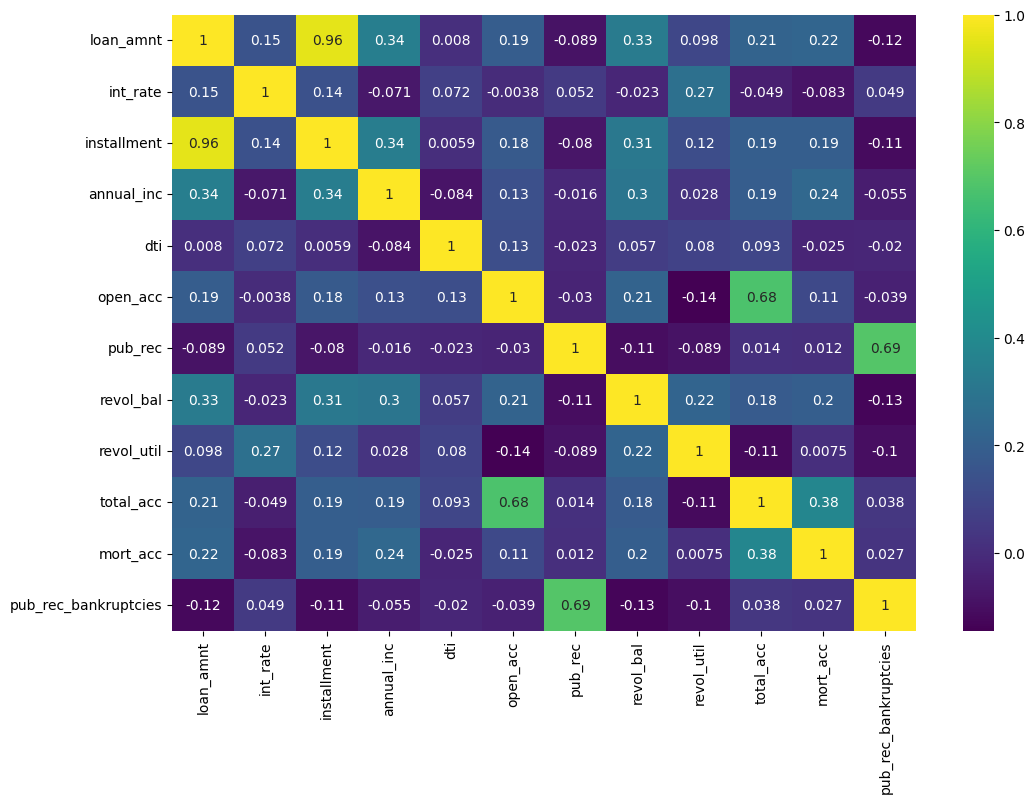

In [ ]:
#Data Cleaning first

# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

#Drop missing values and calculating correlation matrix
numeric_data = numeric_data.dropna()
corr_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')

We notice high correlation between 'loan_amnt' and 'installment' which makes sense because when the amount of the loan is huge, naturally the installment will be also relatively huge, and vice versa.

Study of Loan_amnt & Installment

In [ ]:
installment = data.hvplot.hist(
    y='installment', by='loan_status', subplots=False,
    width=350, height=400, bins=50, alpha=0.4,
    title="Installment by Loan Status",
    xlabel='Installment', ylabel='Counts', legend='top'
)

loan_amnt = data.hvplot.hist(
    y='loan_amnt', by='loan_status', subplots=False,
    width=350, height=400, bins=30, alpha=0.4,
    title="Loan Amount by Loan Status",
    xlabel='Loan Amount', ylabel='Counts', legend='top'
)

installment + loan_amnt

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [installment]   (installment_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [loan_amnt]   (loan_amnt_count)

In [ ]:
loan_amnt_box = data.hvplot.box(
    y='loan_amnt', subplots=True, by='loan_status', width=300, height=350,
    title="Loan Status by Loan Amount ", xlabel='Loan Status', ylabel='Loan Amount'
)

installment_box = data.hvplot.box(
    y='installment', subplots=True, by='loan_status', width=300, height=350,
    title="Loan Status by Installment", xlabel='Loan Status', ylabel='Installment'
)

loan_amnt_box + installment_box

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .BoxWhisker.I  :BoxWhisker   [loan_status]   (loan_amnt)
   .BoxWhisker.II :BoxWhisker   [loan_status]   (installment)

In [ ]:
data.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.00,15126.30,8505.09,1000.00,8525.00,14000.00,20000.00,40000.00
Fully Paid,318357.00,13866.88,8302.32,500.00,7500.00,12000.00,19225.00,40000.00


Study of grade & sub_grade.


In [ ]:
print(f"GRADE unique: {data.grade.unique()}")
print(f"SUB_GRADE unique: {data.sub_grade.unique()}")

GRADE unique: ['B' 'A' 'C' 'E' 'D' 'F' 'G']
SUB_GRADE unique: ['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1' 'F3' 'G5' 'G4' 'F2' 'G3']


In [ ]:
# fully_paid = data.loc[data['loan_status']=='Fully Paid', 'grade'].value_counts().hvplot.bar()
# charged_off = data.loc[data['loan_status']=='Charged Off', 'grade'].value_counts().hvplot.bar()

# grades = (fully_paid * charged_off).opts(
#     title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
#     width=500, height=450, legend_cols=2, legend_position='top_right'
# )

# fully_paid = data.loc[data['loan_status']=='Fully Paid', 'sub_grade'].value_counts().hvplot.bar()
# charged_off = data.loc[data['loan_status']=='Charged Off', 'sub_grade'].value_counts().hvplot.bar()

# sub_grades = (fully_paid * charged_off).opts(
#     title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
#     width=500, height=450, legend_cols=2, legend_position='top_right',
#     shared_axes=False
# )

# grades + sub_grades

In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'grade'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'grade'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
    width=500, height=450, legend_cols=2, legend_position='top_right', xrotation=90
)

:Overlay
   .Bars.Count.I  :Bars   [grade]   (count)
   .Bars.Count.II :Bars   [grade]   (count)

In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'sub_grade'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'sub_grade'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
    width=500, height=400, legend_cols=2, legend_position='top_right', xrotation=90
)

:Overlay
   .Bars.Count.I  :Bars   [sub_grade]   (count)
   .Bars.Count.II :Bars   [sub_grade]   (count)

<ipython-input-16-436f83565516>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


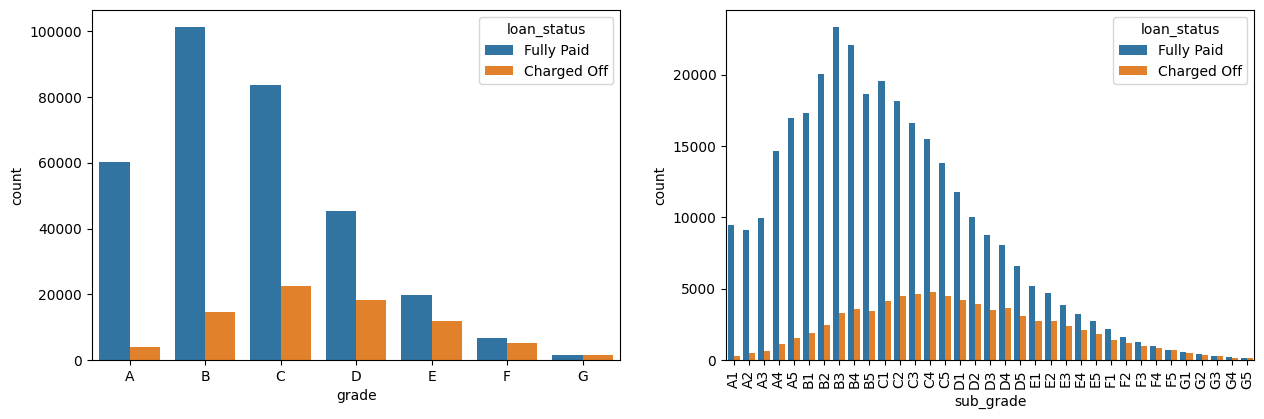

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

It appears that loans with F and G subgrades have a lower repayment rate. Let's isolate these subgrades and generate a count plot specifically for them.

<Axes: xlabel='sub_grade', ylabel='count'>

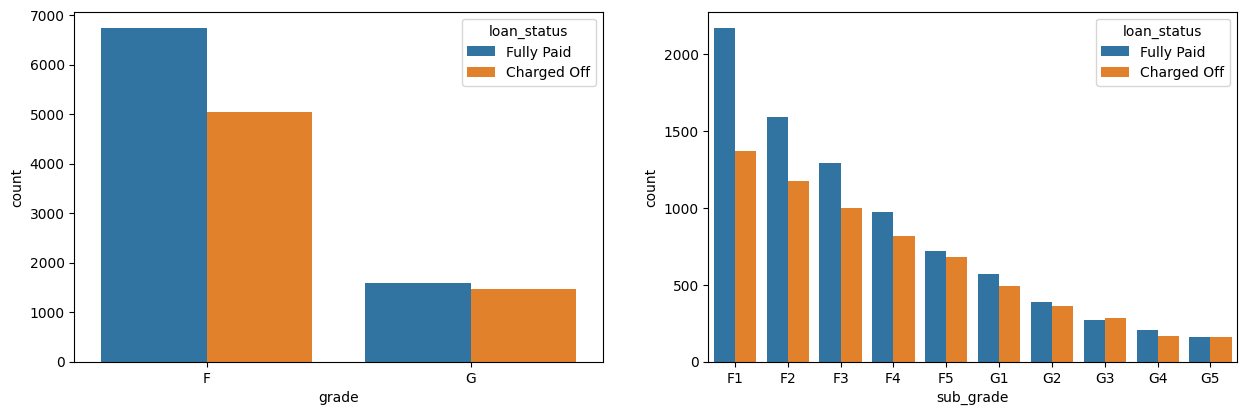

In [ ]:
df = data[(data.grade == 'F') | (data.grade == 'G')]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)

Study of term, home_ownership, verification_status & purpose.


In [ ]:
data['home_ownership'].value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64

In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'home_ownership'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'home_ownership'].value_counts().hvplot.bar()

home_ownership_count = (fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=90)

home_ownership = data.home_ownership.value_counts().hvplot.bar(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count',
    width=350, height=350, legend='top'
).opts(xrotation=90)

(home_ownership_count + home_ownership)

/usr/local/lib/python3.10/dist-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/usr/local/lib/python3.10/dist-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .Overlay.Count :Overlay
      .Bars.Count.I  :Bars   [home_ownership]   (count)
      .Bars.Count.II :Bars   [home_ownership]   (count)
   .Bars.Count    :Bars   [home_ownership]   (count)

In [ ]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'
data.home_ownership.value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: count, dtype: int64

<ipython-input-21-62191b24ebc8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


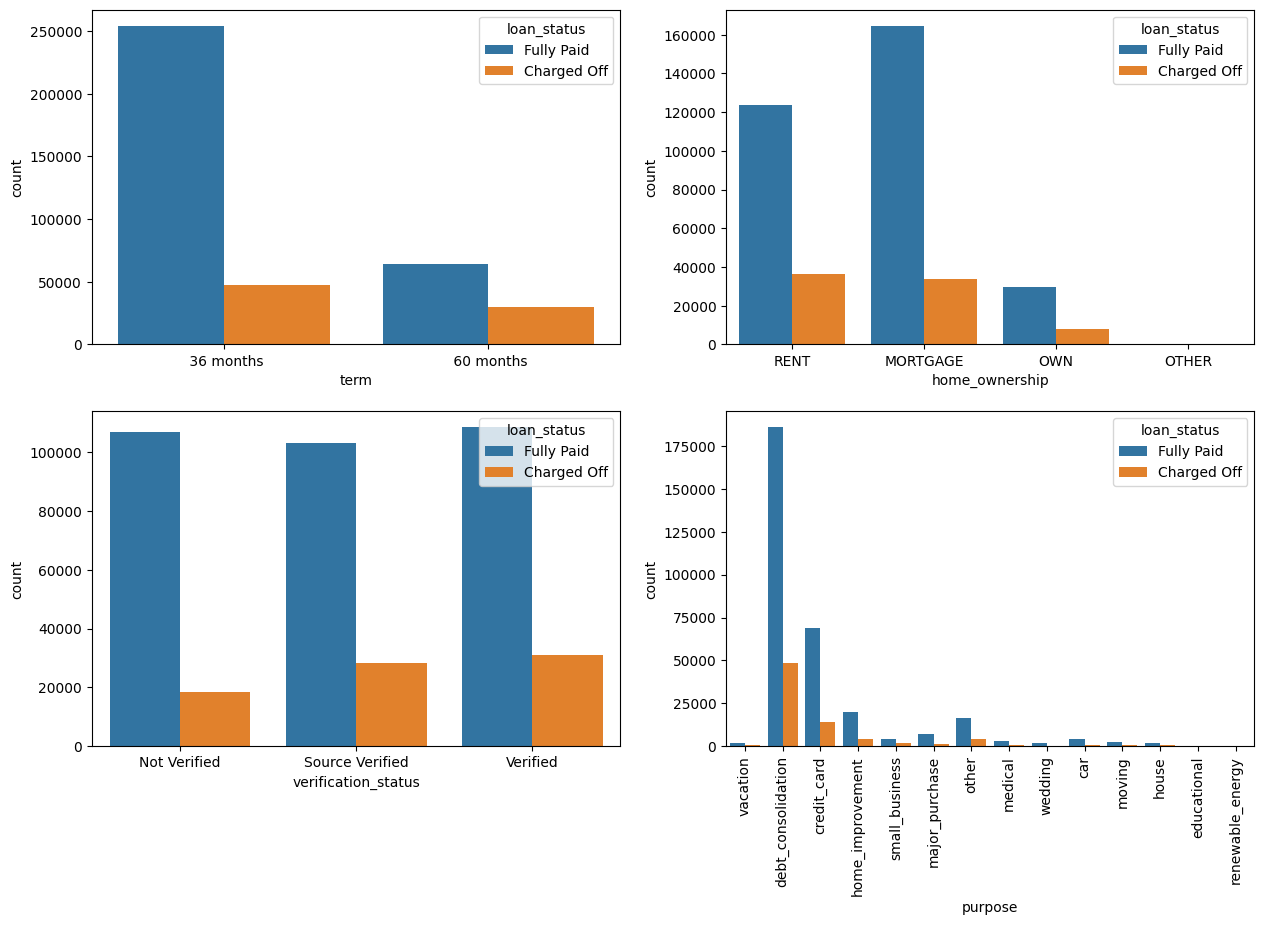

In [ ]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [ ]:
data.loc[data['home_ownership']=='OTHER', 'loan_status'].value_counts()

loan_status
Fully Paid     123
Charged Off     23
Name: count, dtype: int64

Study of int_rate & annual_inc


In [ ]:
int_rate = data.hvplot.hist(
    y='int_rate', by='loan_status', alpha=0.3, width=350, height=400,
    title="Loan Status by Interest Rate", xlabel='Interest Rate', ylabel='Loans Counts',
    legend='top'
)

annual_inc = data.hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Annual Income", xlabel='Annual Income', ylabel='Loans Counts',
    legend='top'
).opts(xrotation=45)

int_rate + annual_inc

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [int_rate]   (int_rate_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [annual_inc]   (annual_inc_count)

In [ ]:
data[data.annual_inc <= 250000].hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=500, height=400,
    title="Loan Status by Annual Income (<= 250000/Year)",
    xlabel='Annual Income', ylabel='Loans Counts', legend='top'
).opts(xrotation=45)

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:NdOverlay   [loan_status]
   :Histogram   [annual_inc]   (annual_inc_count)

In [ ]:
print((data[data.annual_inc >= 250000].shape[0] / data.shape[0]) * 100)
print((data[data.annual_inc >= 1000000].shape[0] / data.shape[0]) * 100)

1.0294674645860162
0.018937959245511705


In [ ]:
data.loc[data.annual_inc >= 1000000, 'loan_status'].value_counts()

loan_status
Fully Paid     65
Charged Off    10
Name: count, dtype: int64

In [ ]:
data.loc[data.annual_inc >= 250000, 'loan_status'].value_counts()

loan_status
Fully Paid     3509
Charged Off     568
Name: count, dtype: int64

It seems loans with high interest rate are likely to be unpaid

Study of emp_title & emp_length.


In [ ]:
print(data.emp_title.isna().sum())
print(data.emp_title.nunique())

22927
173105


In [ ]:
data['emp_title'].value_counts()[:20]

emp_title
Teacher                     4389
Manager                     4250
Registered Nurse            1856
RN                          1846
Supervisor                  1830
Sales                       1638
Project Manager             1505
Owner                       1410
Driver                      1339
Office Manager              1218
manager                     1145
Director                    1089
General Manager             1074
Engineer                     995
teacher                      962
driver                       882
Vice President               857
Operations Manager           763
Administrative Assistant     756
Accountant                   748
Name: count, dtype: int64

<ipython-input-30-ef23f0b89a49>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


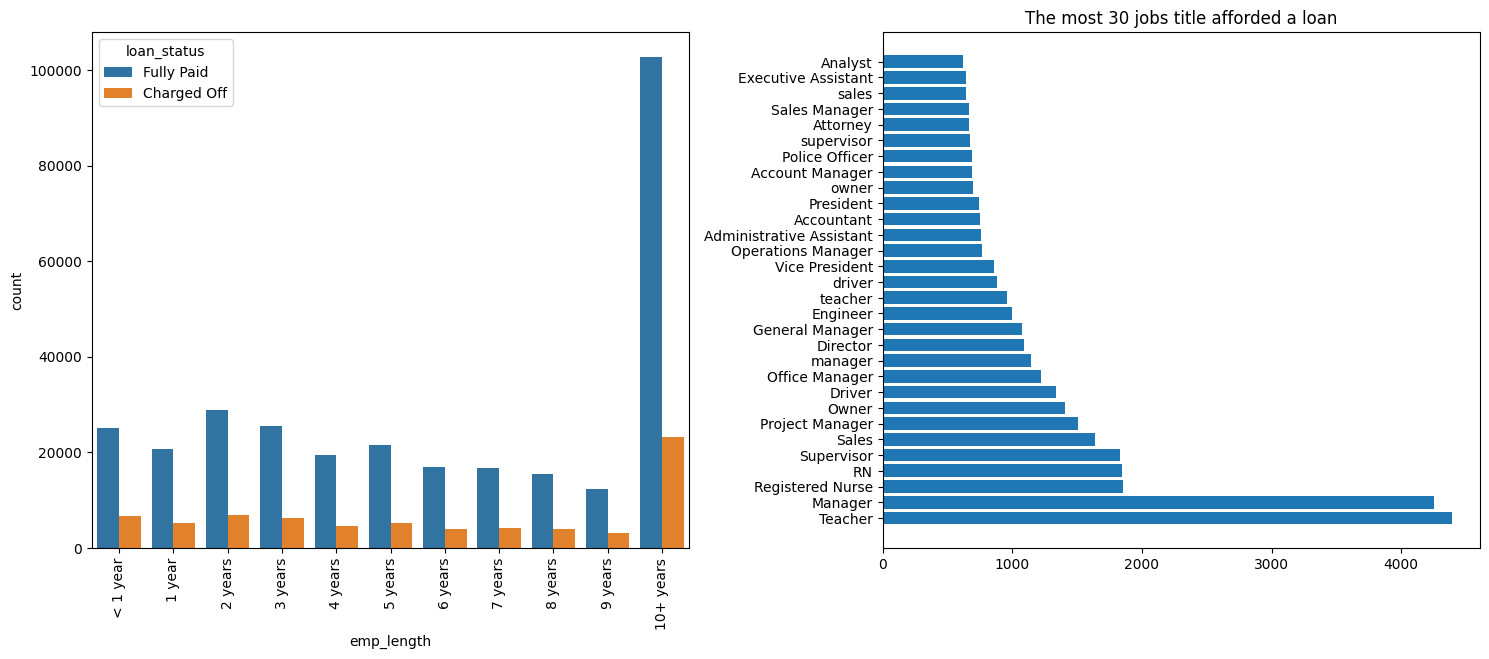

In [ ]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=data, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

plt.subplot(2, 2, 2)
plt.barh(data.emp_title.value_counts()[:30].index, data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a loan")
plt.tight_layout()

Study of issue_d & earliest_cr_line.


In [ ]:
data['earliest_cr_line'].value_counts()

earliest_cr_line
Oct-2000    3017
Aug-2000    2935
Oct-2001    2896
Aug-2001    2884
Nov-2000    2736
            ... 
Jul-1958       1
Nov-1957       1
Jan-1953       1
Jul-1955       1
Aug-1959       1
Name: count, Length: 684, dtype: int64

In [ ]:
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

<ipython-input-32-2f9ecc54f8c2>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['issue_d'] = pd.to_datetime(data['issue_d'])
<ipython-input-32-2f9ecc54f8c2>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])


In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'issue_d'].hvplot.hist(bins=35)
charged_off = data.loc[data['loan_status']=='Charged Off', 'issue_d'].hvplot.hist(bins=35)

# fully_paid * charged_off
loan_issue_date = (fully_paid * charged_off).opts(
    title="Loan Status by Loan Issue Date", xlabel='Loan Issue Date', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'earliest_cr_line'].hvplot.hist(bins=35)
charged_off = data.loc[data['loan_status']=='Charged Off', 'earliest_cr_line'].hvplot.hist(bins=35)

earliest_cr_line = (fully_paid * charged_off).opts(
    title="Loan Status by earliest_cr_line", xlabel='earliest_cr_line', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

loan_issue_date + earliest_cr_line

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .Overlay.I  :Overlay
      .Histogram.I  :Histogram   [issue_d]   (issue_d_count)
      .Histogram.II :Histogram   [issue_d]   (issue_d_count)
   .Overlay.II :Overlay
      .Histogram.I  :Histogram   [earliest_cr_line]   (earliest_cr_line_count)
      .Histogram.II :Histogram   [earliest_cr_line]   (earliest_cr_line_count)

Study of title. (unimportant)

In [ ]:
data.title.isna().sum()

1756

In [ ]:
data['title'] = data.title.str.lower()

In [ ]:
data.title.value_counts()[:10]

title
debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
Name: count, dtype: int64

Study of dti, open_acc, revol_bal, revol_util, & total_acc.

In [ ]:
data.dti.value_counts()

dti
0.00     313
14.40    310
19.20    302
16.80    301
18.00    300
        ... 
59.18      1
48.37      1
45.71      1
42.38      1
55.53      1
Name: count, Length: 4262, dtype: int64

In [ ]:
dti = data.hvplot.hist(
    y='dti', bins=50, width=350, height=350,
    title="dti Distribution", xlabel='dti', ylabel='Count'
)

sub_dti = data[data['dti']<=50].hvplot.hist(
    y='dti', bins=50, width=350, height=350,
    title="dti (<=30) Distribution", xlabel='dti', ylabel='Count', shared_axes=False
)

dti + sub_dti

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .Histogram.I  :Histogram   [dti]   (dti_count)
   .Histogram.II :Histogram   [dti]   (dti_count)

In [ ]:
print(data[data['dti']>=40].shape)

(296, 27)


In [ ]:
data.loc[data['dti']>=50, 'loan_status'].value_counts()

loan_status
Fully Paid     26
Charged Off     9
Name: count, dtype: int64

In [ ]:
dti = data[data['dti']<=50].hvplot.hist(
    y='dti', by='loan_status', bins=50, width=300, height=350,
    title="dti (<=30) Distribution", xlabel='dti', ylabel='Count',
    alpha=0.3, legend='top'
)

title="Loan Status by The number of open credit lines"

open_acc = data.hvplot.hist(
    y='open_acc', by='loan_status', bins=50, width=300, height=350,
    title=title, xlabel='The number of open credit lines', ylabel='Count',
    alpha=0.4, legend='top'
)

title="Loan Status by The total number of credit lines"

total_acc = data.hvplot.hist(
    y='total_acc', by='loan_status', bins=50, width=300, height=350,
    title=title, xlabel='The total number of credit lines', ylabel='Count',
    alpha=0.4, legend='top'
)

dti + open_acc + total_acc

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .NdOverlay.I   :NdOverlay   [loan_status]
      :Histogram   [dti]   (dti_count)
   .NdOverlay.II  :NdOverlay   [loan_status]
      :Histogram   [open_acc]   (open_acc_count)
   .NdOverlay.III :NdOverlay   [loan_status]
      :Histogram   [total_acc]   (total_acc_count)

In [ ]:
print(data.shape)
print(data[data.open_acc > 40].shape)

(396030, 27)
(217, 27)


In [ ]:
print(data.shape)
print(data[data.total_acc > 80].shape)

(396030, 27)
(266, 27)


In [ ]:
print(data.shape)
print(data[data.revol_util > 120].shape)

(396030, 27)
(27, 27)


In [ ]:
title="Loan Status by Revolving line utilization rate"

revol_util = data.hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=350, height=400,
    title=title, xlabel='Revolving line utilization rate', ylabel='Count',
    alpha=0.4, legend='top'
)

title="Loan Status by Revolving line utilization rate (<120)"

sub_revol_util = data[data.revol_util < 120].hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=350, height=400,
    title=title, xlabel='Revolving line utilization rate', ylabel='Count',
    shared_axes=False, alpha=0.4, legend='top'
)

revol_util + sub_revol_util

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (revol_util_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (revol_util_count)

In [ ]:
data[data.revol_util > 200]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
137211,3500.00,36 months,12.49,117.08,B,B4,Budget Analyst,10+ years,RENT,45000.00,Verified,2014-04-01,Fully Paid,debt_consolidation,debt consolidation,14.67,1998-10-01,2.00,0.00,2677.00,892.30,9.00,f,INDIVIDUAL,0.00,0.00,"12506 Connie Burg\nVelasquezfort, TN 00813"


In [ ]:
print(data.shape)
print(data[data.revol_bal > 250000].shape)

(396030, 27)
(397, 27)


In [ ]:
title = "Loan Status by Total credit revolving balance"

revol_bal = data.hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400,
    title=title, xlabel='Total credit revolving balance', ylabel='Count',
    alpha=0.4, legend='top'
)

title = "Loan Status by Total credit revolving balance (<250000)"

sub_revol_bal = data[data['revol_bal']<=250000].hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400,
    title=title, xlabel='Total credit revolving balance', ylabel='Count',
    alpha=0.4, legend='top', shared_axes=False
).opts(xrotation=45)

revol_bal + sub_revol_bal

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)

In [ ]:
data.loc[data.revol_bal > 250000, 'loan_status'].value_counts()

loan_status
Fully Paid     351
Charged Off     46
Name: count, dtype: int64

It seems the smaller the dti, the loan will more likely unpaid.

Study of pub_rec, initial_list_status, application_type, mort_acc, & pub_rec_bankruptcies.

In [ ]:
xlabel = 'Number of derogatory public records'
title = "Loan Status by Number of derogatory public records"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'pub_rec'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'pub_rec'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [pub_rec]   (count)
   .Bars.Count.II :Bars   [pub_rec]   (count)

In [ ]:
xlabel = "The initial listing status of the loan"
title = "Loan Status by The initial listing status of the loan"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'initial_list_status'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'initial_list_status'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [initial_list_status]   (count)
   .Bars.Count.II :Bars   [initial_list_status]   (count)

In [ ]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'application_type'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'application_type'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title="Loan Status by Application Type", xlabel="Application Type", ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [application_type]   (count)
   .Bars.Count.II :Bars   [application_type]   (count)

In [ ]:
xlabel = "Number of public record bankruptcies"
title = "Loan Status by The Number of public record bankruptcies"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'pub_rec_bankruptcies'].value_counts().hvplot.bar()
charged_off = data.loc[data['loan_status']=='Charged Off', 'pub_rec_bankruptcies'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [pub_rec_bankruptcies]   (count)
   .Bars.Count.II :Bars   [pub_rec_bankruptcies]   (count)

In [ ]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [ ]:
data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<Axes: xlabel='pub_rec_bankruptcies', ylabel='count'>

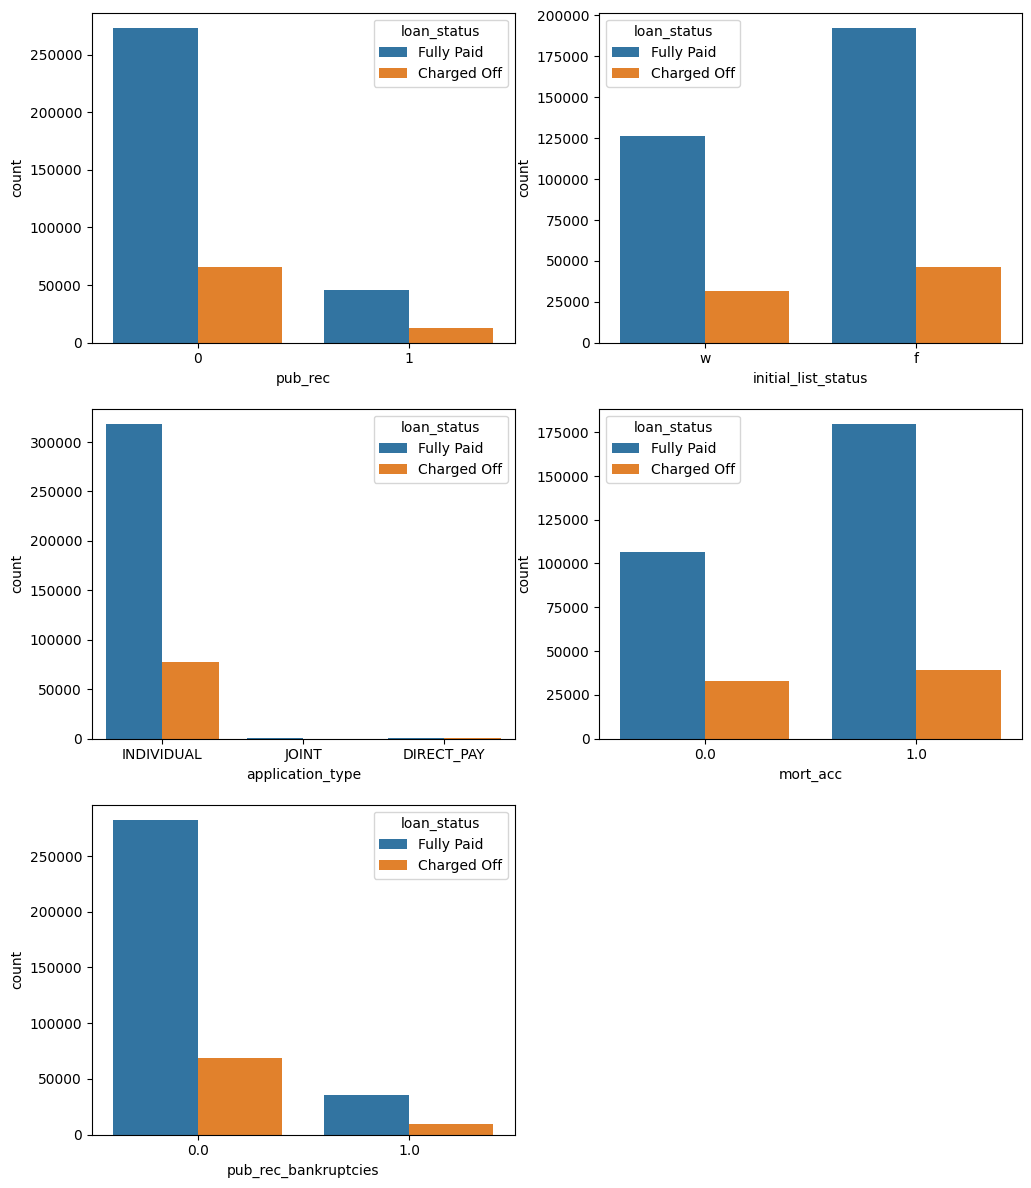

In [ ]:
plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=data, hue='loan_status')

plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=data, hue='loan_status')

plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=data, hue='loan_status')

plt.subplot(6, 2, 4)
sns.countplot(x='mort_acc', data=data, hue='loan_status')

plt.subplot(6, 2, 5)
sns.countplot(x='pub_rec_bankruptcies', data=data, hue='loan_status')

How the numeric features correlate with the target variable?

In [ ]:
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})
numeric_data = data.select_dtypes(include=[float, int])


In [ ]:
corr_values = numeric_data.corr()['loan_status'].drop('loan_status').sort_values()
corr_values.hvplot.barh(
    width=600, height=400,
    title="Correlation between Loan status and Numeric Features",
    ylabel='Correlation', xlabel='Numerical Features'
)

:Bars   [index]   (loan_status)

We observe that the features can be categorized into three broad types:

Applicant-related features (e.g., demographic variables such as occupation, employment details, etc.).
Loan characteristic features (e.g., loan amount, interest rate, purpose of the loan, etc.).

Data PreProcessing

1. Remove or fill any missing data.
2. Remove unnecessary or repetitive features.
3. Convert categorical string features to dummy variables.

In [ ]:
# The length of the data
print(f"The Length of the data: {data.shape}")

The Length of the data: (396030, 27)


In [ ]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1756' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


emp_title

In [ ]:
data.emp_title.nunique()

173105

We will remove this column since there are too many unique job titles to try to convert this to a dummy variable feature.

In [ ]:
data.drop('emp_title', axis=1, inplace=True)

emp_length

In [ ]:
data.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [ ]:
for year in data.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:
loan_status
1   0.82
0   0.18
Name: proportion, dtype: float64
4 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
< 1 year years in this position:
loan_status
1   0.79
0   0.21
Name: proportion, dtype: float64
6 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
9 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
2 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
3 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
8 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
7 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
5 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
1 year years in this position:
loan_status
1   

Charge off rates are quite similar across all employment lengths, so we are going to drop this column too.

In [ ]:
data.drop('emp_length', axis=1, inplace=True)

title

In [ ]:
data.title.value_counts().head()

title
debt consolidation         168108
credit card refinancing     51781
home improvement            17117
other                       12993
consolidation                5583
Name: count, dtype: int64

In [ ]:
data.purpose.value_counts().head()

purpose
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
Name: count, dtype: int64

It is simply a string, a description, hence we are going to drop it too.

In [ ]:
data.drop('title', axis=1, inplace=True)

mort_acc

In [ ]:
data.mort_acc.value_counts()

mort_acc
1.00    218458
0.00    139777
Name: count, dtype: int64

In [ ]:
data.mort_acc.isna().sum()

37795

In [ ]:
numeric_data = data.select_dtypes(include=[float, int])
corr_values = numeric_data.corr()['mort_acc'].drop('mort_acc').sort_values()
corr_values.hvplot.barh(
    width=600, height=400,
    title="Correlation between Mortgage Account and Numeric Features",
    ylabel='Correlation', xlabel='Numerical Features'
)

:Bars   [index]   (mort_acc)

It appears that the total_acc feature correlates with mort_acc, which is logical. Let's use the fillna() method to handle missing values. We will group the dataframe by total_acc and calculate the mean value of mort_acc for each total_acc entry.

In [ ]:
# Convert relevant columns to numeric if necessary
data['term'] = data['term'].str.extract('(\d+)').astype(float)

# Ensure `total_acc` and `mort_acc` are numeric
data['total_acc'] = pd.to_numeric(data['total_acc'], errors='coerce')
data['mort_acc'] = pd.to_numeric(data['mort_acc'], errors='coerce')

# Calculate the mean mort_acc for each total_acc
total_acc_avg = data.groupby('total_acc')['mort_acc'].mean()

# Fill missing values in mort_acc using the calculated mean values
data['mort_acc'] = data.apply(lambda x: total_acc_avg[x['total_acc']] if pd.isnull(x['mort_acc']) else x['mort_acc'], axis=1)


revol_util & pub_rec_bankruptcies

In [ ]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(395219, 24)

Categorical Variables and Dummy Variables

In [ ]:
print([column for column in data.columns if data[column].dtype == object])

['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'address']


term

In [ ]:
data.term.unique()

array([36., 60.])

In [ ]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

In [ ]:
data.term.unique()

array([nan])

grade & sub_grade

We know that grade is just a sub feature of sub_grade, so we are goinig to drop it.

In [ ]:
data.drop('grade', axis=1, inplace=True)

In [ ]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status',
           'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

address

We are going to feature engineer a zip code column from the address in the data set. Create a column called 'zip_code' that extracts the zip code from the address column.

In [ ]:
data.address.head()

0       0174 Michelle Gateway\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3              823 Reid Ford\nDelacruzside, MA 00813
4               679 Luna Roads\nGreggshire, VA 11650
Name: address, dtype: object

In [ ]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [ ]:
data.zip_code.value_counts()

zip_code
70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: count, dtype: int64

In [ ]:
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

In [ ]:
data.drop('address', axis=1, inplace=True)

issue_d

This would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.

In [ ]:
data.drop('issue_d', axis=1, inplace=True)

earliest_cr_line

This appears to be a historical time stamp feature. Extract the year from this feature, then convert it to a numeric feature.

In [ ]:
data['earliest_cr_line'] = data.earliest_cr_line.dt.year

In [ ]:
data.earliest_cr_line.nunique()

65

In [ ]:
data.earliest_cr_line.value_counts()

earliest_cr_line
2000    29302
2001    29031
1999    26444
2002    25849
2003    23623
        ...  
1951        3
1950        3
1953        2
1944        1
1948        1
Name: count, Length: 65, dtype: int64

Train Test Split

In [ ]:
w_p = data.loan_status.value_counts()[0] / data.shape[0]
w_n = data.loan_status.value_counts()[1] / data.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.19615200686201828
Weight of negative values 0.8038479931379817


In [ ]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(264796, 79)
(130423, 79)


Removing outliers

In [ ]:
print(train[train['dti'] <= 50].shape)
print(train.shape)

(264776, 79)
(264796, 79)


In [ ]:
print(train.shape)
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(train.shape)

(264796, 79)
(262143, 79)


Normalizing the data

In [ ]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [ ]:
X_train.dtypes

loan_amnt         float64
term              float64
int_rate          float64
installment       float64
annual_inc        float64
                   ...   
zip_code_30723       bool
zip_code_48052       bool
zip_code_70466       bool
zip_code_86630       bool
zip_code_93700       bool
Length: 78, dtype: object

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Approaches and building models

In [ ]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [ ]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

Artificial Neural Networks (ANNs)

In [ ]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [ ]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
8192/8192 [==============================] - 51s 6ms/step - loss: nan - AUC: 0.0000e+00 - val_loss: nan - val_AUC: 0.0000e+00
Epoch 2/20
8192/8192 [==============================] - 46s 6ms/step - loss: nan - AUC: 0.0000e+00 - val_loss: nan - val_AUC: 0.0000e+00
Epoch 3/20
8192/8192 [==============================] - 45s 6ms/step - loss: nan - AUC: 0.0000e+00 - val_loss: nan - val_AUC: 0.0000e+00
Epoch 4/20
8192/8192 [==============================] - 47s 6ms/step - loss: nan - AUC: 0.0000e+00 - val_loss: nan - val_AUC: 0.0000e+00
Epoch 5/20
8192/8192 [==============================] - 46s 6ms/step - loss: nan - AUC: 0.0000e+00 - val_loss: nan - val_AUC: 0.0000e+00
Epoch 6/20
8192/8192 [==============================] - 45s 6ms/step - loss: nan - AUC: 0.0000e+00 - val_loss: nan - val_AUC: 0.0000e+00
Epoch 7/20
8192/8192 [==============================] - 48s 6ms/step - loss: nan - AUC: 0.0000e+00 - val_loss: nan - val_AUC: 0.0000e+00
Epoch 8/20
8192/8192 [===================

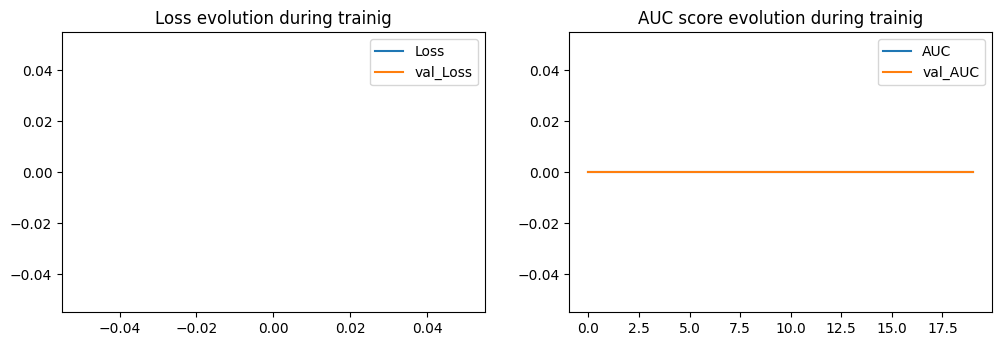

In [ ]:
plot_learning_evolution(r)

In [ ]:
y_train_pred = model.predict(X_train)

# Check for NaNs in the predictions
if np.isnan(y_train_pred).any():
    print("NaN values found in the predictions")
    # Handle NaNs, fill with a default value (e.g., 0)
    y_train_pred = np.nan_to_num(y_train_pred, nan=0.0)

evaluate_nn(y_train, y_train_pred.round(), train=True)

8192/8192 [==============================] - 15s 2ms/step
NaN values found in the predictions


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Result:
Accuracy Score: 19.71%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.20      0.00      0.20       0.10          0.04
recall        1.00      0.00      0.20       0.50          0.20
f1-score      0.33      0.00      0.20       0.16          0.06
support   51665.00 210478.00      0.20  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 51665      0]
 [210478      0]]



In [ ]:
y_test_pred = model.predict(X_test)
# Check for NaNs in the predictions
if np.isnan(y_test_pred).any():
    print("NaN values found in the predictions")
    # Handle NaNs, fill with a default value (e.g., 0)
    y_test_pred = np.nan_to_num(y_test_pred, nan=0.0)

evaluate_nn(y_test, y_test_pred.round(), train=False)

4076/4076 [==============================] - 9s 2ms/step
NaN values found in the predictions


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Result:
Accuracy Score: 19.54%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.20      0.00      0.20       0.10          0.04
recall        1.00      0.00      0.20       0.50          0.20
f1-score      0.33      0.00      0.20       0.16          0.06
support   25480.00 104943.00      0.20  130423.00     130423.00
_______________________________________________
Confusion Matrix: 
 [[ 25480      0]
 [104943      0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Predict the training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Check for NaNs in the predictions and handle them
if np.isnan(y_train_pred).any():
    print("NaN values found in the training predictions")
    y_train_pred = np.nan_to_num(y_train_pred, nan=0.0)

if np.isnan(y_test_pred).any():
    print("NaN values found in the test predictions")
    y_test_pred = np.nan_to_num(y_test_pred, nan=0.0)

# Calculate the ROC AUC scores
scores_dict = {
    'ANNs': {
        'Train': roc_auc_score(y_train, y_train_pred),
        'Test': roc_auc_score(y_test, y_test_pred),
    },
}

# Output the scores dictionary
scores_dict

4076/4076 [==============================] - 8s 2ms/step
NaN values found in the training predictions
NaN values found in the test predictions


{'ANNs': {'Train': 0.5, 'Test': 0.5}}

#XGBoost Classifier

In [ ]:
# param_grid = dict(
#     n_estimators=stats.randint(10, 500),
#     max_depth=stats.randint(1, 10),
#     learning_rate=stats.uniform(0, 1)
# )

xgb_clf = XGBClassifier(use_label_encoder=False)
# xgb_cv = RandomizedSearchCV(
#     xgb_clf, param_grid, cv=3, n_iter=60,
#     scoring='roc_auc', n_jobs=-1, verbose=1
# )
# xgb_cv.fit(X_train, y_train)

# best_params = xgb_cv.best_params_
# best_params['tree_method'] = 'gpu_hist'
# # best_params = {'n_estimators': 50, 'tree_method': 'gpu_hist'}
# print(f"Best Parameters: {best_params}")

# xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 89.64%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.95      0.89      0.90       0.92          0.90
recall        0.50      0.99      0.90       0.75          0.90
f1-score      0.66      0.94      0.90       0.80          0.88
support   51665.00 210478.00      0.90  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 25905  25760]
 [  1389 209089]]

Test Result:
Accuracy Score: 88.94%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.91      0.89      0.89       0.90          0.89
recall        0.48      0.99      0.89       0.73          0.89
f1-score      0.63      0.94      0.89       0.78          0.88
support   25480.00 104943.00      0.89  130423.00     130423.00
_________________________________________

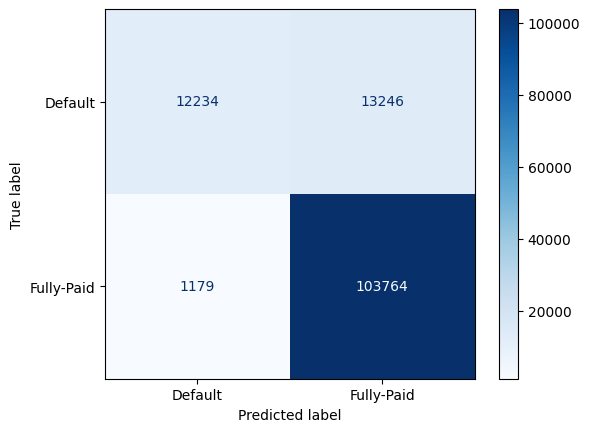

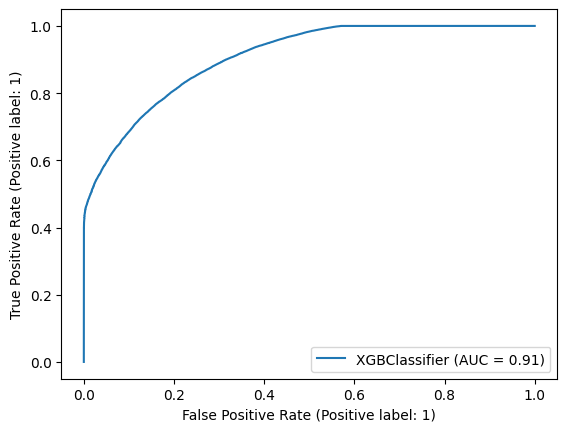

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

In [ ]:
scores_dict['XGBoost'] = {
        'Train': roc_auc_score(y_train, xgb_clf.predict(X_train)),
        'Test': roc_auc_score(y_test, xgb_clf.predict(X_test)),
    }

Random forest classifier then comparing performances.

In [ ]:
from sklearn.impute import SimpleImputer

# Fit the imputer on the training data and transform both training and test sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Fit the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_imputed, y_train)

# Fit the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_imputed, y_train)

# Define and fit the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train_imputed.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_imputed, y_train, epochs=10, batch_size=32, verbose=1)  # Adjust epochs and batch_size as needed

# Define the models dictionary with the fitted models
ml_models = {
    'RandomForest': rf_clf,
    'XGBoost': xgb_clf,
    'ANNs': model  # Ensure 'model' is the neural network model instance
}

# Evaluate models using roc_auc_score
for model_name, model_instance in ml_models.items():
    y_test_pred = model_instance.predict(X_test_imputed)
    if model_name == 'ANNs':  # For neural network models, use .predict() and then round the predictions
        y_test_pred = np.round(y_test_pred)
    print(f"{model_name.upper():{30}} roc_auc_score: {roc_auc_score(y_test, y_test_pred):.3f}")

Epoch 1/10
8192/8192 [==============================] - 18s 2ms/step - loss: 0.2730 - accuracy: 0.8846
Epoch 2/10
8192/8192 [==============================] - 17s 2ms/step - loss: 0.2614 - accuracy: 0.8879
Epoch 3/10
8192/8192 [==============================] - 17s 2ms/step - loss: 0.2594 - accuracy: 0.8883
Epoch 4/10
8192/8192 [==============================] - 18s 2ms/step - loss: 0.2585 - accuracy: 0.8884
Epoch 5/10
8192/8192 [==============================] - 18s 2ms/step - loss: 0.2578 - accuracy: 0.8886
Epoch 6/10
8192/8192 [==============================] - 17s 2ms/step - loss: 0.2573 - accuracy: 0.8889
Epoch 7/10
8192/8192 [==============================] - 17s 2ms/step - loss: 0.2567 - accuracy: 0.8888
Epoch 8/10
8192/8192 [==============================] - 19s 2ms/step - loss: 0.2564 - accuracy: 0.8893
Epoch 9/10
8192/8192 [==============================] - 17s 2ms/step - loss: 0.2559 - accuracy: 0.8894
Epoch 10/10
8192/8192 [==============================] - 18s 2ms/step - l

In [ ]:
# Evaluate models using roc_auc_score and populate the scores_dict
scores_dict = {}

for model_name, model_instance in ml_models.items():
    y_test_pred = model_instance.predict(X_test_imputed)
    if model_name == 'ANNs':  # For neural network models, use .predict() and then round the predictions
        y_test_pred = np.round(y_test_pred)
    scores_dict[model_name] = roc_auc_score(y_test, y_test_pred)

# Convert the scores_dict to a DataFrame
scores_df = pd.DataFrame(list(scores_dict.items()), columns=['Model', 'ROC_AUC_Score'])

# Plot the ROC scores using hvplot
scores_df.hvplot.barh(
    x='Model', y='ROC_AUC_Score',
    width=500, height=400,
    title="ROC Scores of ML Models", xlabel="ROC Scores",
    alpha=0.4, legend='top'
)

4076/4076 [==============================] - 6s 2ms/step


:Bars   [Model]   (ROC_AUC_Score)

**XGBoost Classifier** has the highest ROC AUC score of 0.734, indicating it has the best performance among the three models in distinguishing between the positive and negative classes.
This classifier is known for its robustness, flexibility, and efficiency. It often provides better accuracy compared to other algorithms due to its ability to handle missing data and regularization techniques to prevent overfitting.

***Explainability***:

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 10.7 MB/s eta 0:00:00


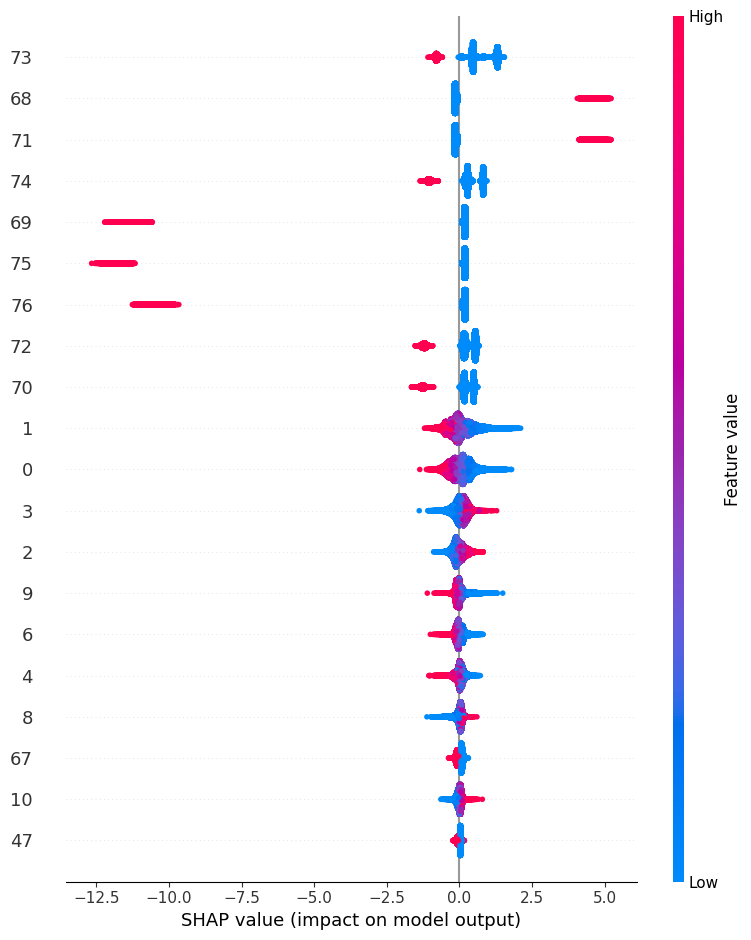

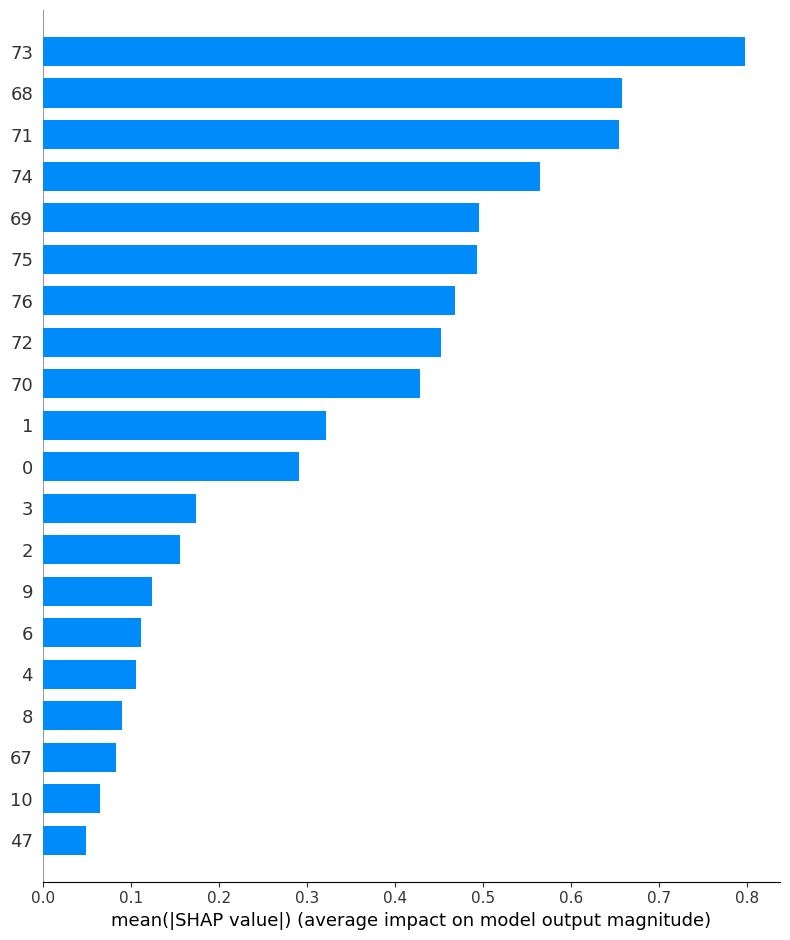

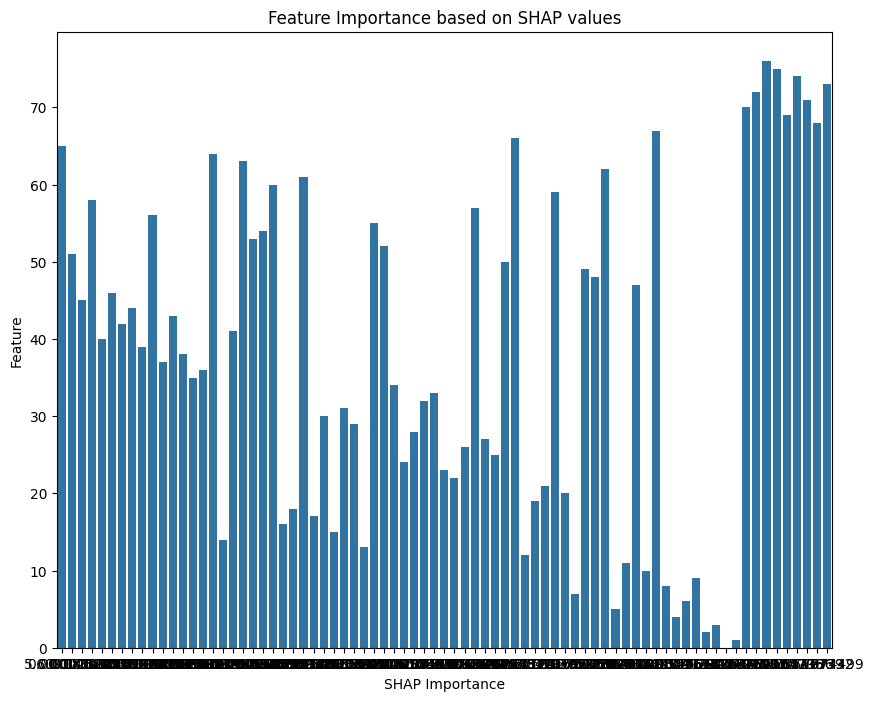

In [ ]:
import shap

# Since we chose the XGBoost classifier, we will load the trained model
# The model variable name is `xgb_clf`

# Ensure X_train has column names if it's a DataFrame
column_names = X_train.columns if hasattr(X_train, 'columns') else None

# Convert X_test_imputed back to a DataFrame
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=column_names)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_imputed_df)

# Summary plot of SHAP values to show the impact of each feature
shap.summary_plot(shap_values, X_test_imputed_df)

# Bar plot of feature importance based on SHAP values
shap.summary_plot(shap_values, X_test_imputed_df, plot_type="bar")

# Explain a single prediction using the SHAP force plot
# For demonstration, we'll use the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_imputed_df.iloc[0])

# Display the feature importance plot using SHAP values
feature_importance = pd.DataFrame(list(zip(X_test_imputed_df.columns, np.abs(shap_values).mean(axis=0))),
                                  columns=['Feature', 'SHAP Importance'])
feature_importance.sort_values(by='SHAP Importance', ascending=False, inplace=True)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='SHAP Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance based on SHAP values')
plt.show()


The above visualizations show which features are most important to the XGBoost model. Few example analysis;

**Annual Income (annual_inc):**

Higher annual income may indicate a lower likelihood of loan default, as the borrower has more financial resources.

**Home Ownership (home_ownership):**

Owning a home may lower the risk of default compared to renting, indicating more financial stability.

***Dicussing additional steps:***

If I had more time and resources, I'd perform the following:

Firstly, regarding time-based:

1. **Hyperparameter Tuning:** Using Bayesian optimization techniques to find the optimal parameters for the XGBoost model and other models.

2. **Advanced Imputation Techniques:** Instead of using simple imputation to handle missing values, we would use deep learning-based imputation to handle missing values more effectively.

Secondly, regarding more resources:

**Bank Transaction Data:** Transaction data from borrowers' bank accounts can provide insights into spending habits, cash flow, and financial behavior.


***Scalability of the Solution***

a. **Number of Loans/Rows in the Training Data**

- Data Volume Handling

Incremental Learning: Implementing incremental learning techniques can help manage large datasets by training the model on chunks of data sequentially. This is particularly useful when the dataset is too large to fit into memory.

b. **Number of Predictions a Possible Inference Endpoint Will Make in Production
Model Serving**

- Scalable Inference Systems: Using scalable model serving frameworks like TensorFlow Serving.

Incremental Learning with XGBoost:

In [ ]:
import xgboost as xgb

# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train_imputed, label=y_train)
dtest = xgb.DMatrix(X_test_imputed, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist'  # Use efficient histogram-based algorithm
}

# Incremental training (e.g., in chunks)
num_round = 100
bst = xgb.train(params, dtrain, num_round)

# Predict using the trained model
y_pred = bst.predict(dtest)
print("AUC score:", roc_auc_score(y_test, y_pred))


AUC score: 0.9067357680197508


To find a way to relate the predictions to the local/global shape of the dataset, we will use **clustering techniques**. Clustering can help us identify groups of similar data points.

It can also help us understand the local structure of the data and then relate it to the predictions made by the model.

We will first start by ***Dimensionality Reduction***, then proceed to ***Clustering*** the data, the finally ***Visualization & Cluster Analysis***.

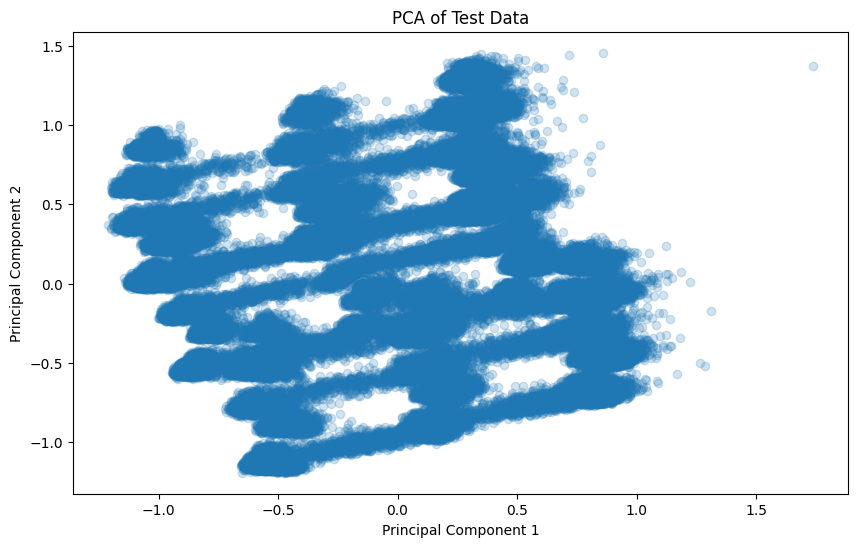

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test_imputed)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.2)
plt.title('PCA of Test Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


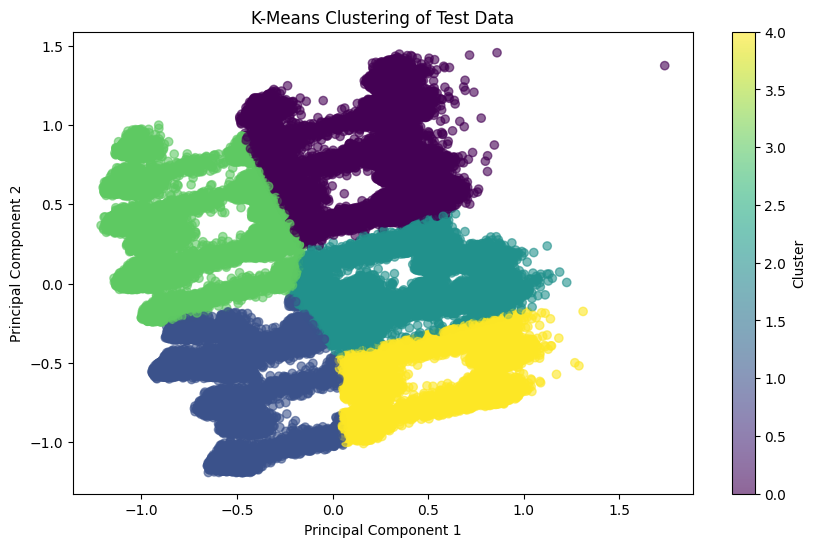

In [ ]:
from sklearn.cluster import KMeans

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('K-Means Clustering of Test Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

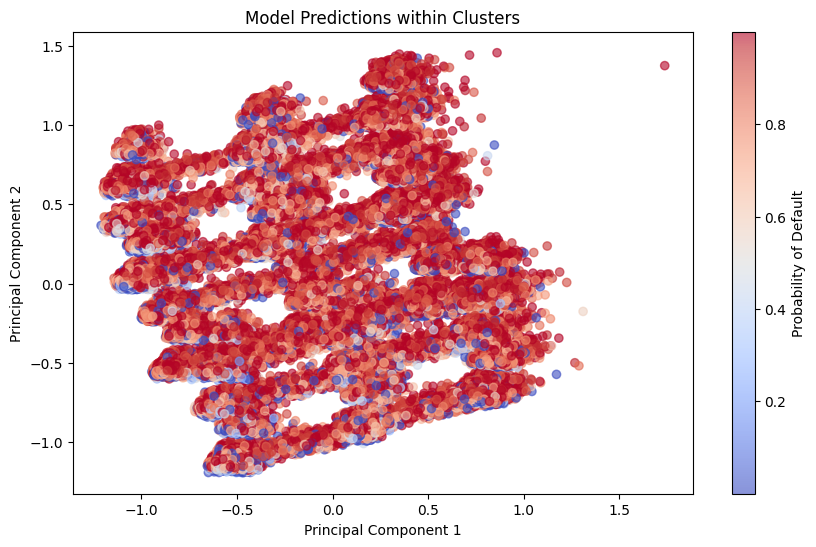

In [ ]:
# Get predictions from the model
y_pred_proba = xgb_clf.predict_proba(X_test_imputed)[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred_proba, cmap='coolwarm', alpha=0.6)
plt.title('Model Predictions within Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Probability of Default')
plt.show()
